# Train Test Val Split

Different strategy of data splitting exists in order to evaluate a Recommendation Model.  
Based on [this paper](https://arxiv.org/pdf/2007.13237.pdf) we'll define our strategy to generate train and test dataset

In [1]:
import pandas as pd
import numpy as np
from utils import read_data

/home/okteto/user_recommendation/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
questions = read_data("questions.json")
answers = read_data("answers.json")

## Data Processing

We add some information to answers dataset such as if an answer has been accepted or not, number of answers per user and number of answers per question.

This will help us to filter our Dataset to better construct train and test datasets.

### Add new information

In [3]:
# Compute nb answers/user 
answers = answers.merge(answers[["user_id" ,"answer_id"]].groupby("user_id").count().reset_index().rename(columns={"answer_id": "user_nb_answers"}),
             on="user_id")
# Compute nb answers/question
answers = answers.merge(answers[["question_id" ,"answer_id"]].groupby("question_id").count().reset_index().rename(columns={"answer_id": "question_nb_answers"}),
             on="question_id")
# Define if an answer has been accepted or not
answers = answers.merge(questions[["accepted_answer_id"]], how="left", left_on="answer_id", right_on="accepted_answer_id")
answers["is_accepted_answer"] = np.where(answers.accepted_answer_id.isna(),
                                          0,
                                          1)

Some stats on these new information

In [4]:
print("Number of users having 2 or more answers:", answers[answers.user_nb_answers>=2].user_id.nunique())
print("Number of remaining questions interacting with users having 2 or more answers:", answers[answers.user_nb_answers>=2].question_id.nunique())
print("\n")
print("Number of questions having 2 or more answers:", answers[answers.question_nb_answers>=3].question_id.nunique())
print("Number of remaining users interacting with questions having 2 or more answers:", answers[answers.question_nb_answers>=3].user_id.nunique())
print("\n")
print("Number of users having answers accepted or score>=2:", answers[(answers.score>=2) | (answers.is_accepted_answer==1)].user_id.nunique())
print("Number of questions having answers accepted or score>=2:", answers[(answers.score>=2) | (answers.is_accepted_answer==1)].question_id.nunique())

Number of users having 2 or more answers: 12365
Number of remaining questions interacting with users having 2 or more answers: 50730


Number of questions having 2 or more answers: 4303
Number of remaining users interacting with questions having 2 or more answers: 9709


Number of users having answers accepted or score>=2: 21952
Number of questions having answers accepted or score>=2: 42235


### Filter positive interaction

In this section we will define what is a positive interaction between a question and a user, i.e the user's answer is relevant.

To do so we will use:
- answer score
- answer acceptation

Regarding to our data exploration, we have seen that **more than 50% of answer have a score of 0**, this means that the majority of answers are not relevant or too recent to be upvoted, in both cases we can't take it as positive interaction.  
Now the question is what is the threshold to apply to the score to define the positivity of an answer ? >=1, >=2, >=?...

In [5]:
# Take a look to the distribution from 0.5 -> 1 percentiles
answers.score.describe(percentiles=[0.5,0.6,0.8,0.85,0.9,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1])

count    95709.000000
mean         0.770889
std          1.639751
min         -5.000000
50%          0.000000
60%          1.000000
80%          1.000000
85%          2.000000
90%          2.000000
92%          2.000000
93%          2.000000
94%          3.000000
95%          3.000000
96%          3.000000
97%          3.000000
98%          4.000000
99%          5.000000
100%       181.000000
max        181.000000
Name: score, dtype: float64

% of remaining answers having been accepted or score>=1: 61 %
% of remaining users having answers accepted or score>=1: 60 %
% of remaining questions having answers accepted or score>=1: 70 %


% of remaining answers having been accepted or score>=2: 46 %
% of remaining users having answers accepted or score>=2: 48 %
% of remaining questions having answers accepted or score>=2: 59 %


% of remaining answers having been accepted or score>=3: 42 %
% of remaining users having answers accepted or score>=3: 45 %
% of remaining questions having answers accepted or score>=3: 56 %


% of remaining answers having been accepted or score>=4: 41 %
% of remaining users having answers accepted or score>=4: 44 %
% of remaining questions having answers accepted or score>=4: 55 %


% of remaining answers having been accepted or score>=5: 40 %
% of remaining users having answers accepted or score>=5: 43 %
% of remaining questions having answers accepted or score>=5: 54 %


% of remaining answers having 

2022-07-16 14:39:57,789 :: switch_backend :: DEBUG :: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-07-16 14:39:57,791 :: switch_backend :: DEBUG :: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-07-16 14:39:57,796 :: _findfont_cached :: DEBUG :: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-07-16 14:39:57,797 :: _findfont_cached :: DEBUG :: findfont: score(FontEntry(fname='/home/okteto/user_recommendation/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-16 14:39:57,798 :: _findfont_cached :: DEBUG :: findfont: score(FontEntry(fname='/home/okteto/user_recommendation/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='n

% of remaining questions having answers accepted or score>=8: 54 %


% of remaining answers having been accepted or score>=9: 40 %
% of remaining users having answers accepted or score>=9: 43 %
% of remaining questions having answers accepted or score>=9: 54 %


% of remaining answers having been accepted or score>=10: 40 %
% of remaining users having answers accepted or score>=10: 43 %
% of remaining questions having answers accepted or score>=10: 54 %




2022-07-16 14:39:57,831 :: _findfont_cached :: DEBUG :: findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-16 14:39:57,832 :: _findfont_cached :: DEBUG :: findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-16 14:39:57,833 :: _findfont_cached :: DEBUG :: findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2022-07-16 14:39:57,833 :: _findfont_cached :: DEBUG :: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/okteto/user_recommendation/.venv/lib/pyt

<AxesSubplot:xlabel='score', ylabel='percentage'>

2022-07-16 14:39:57,938 :: _findfont_cached :: DEBUG :: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-07-16 14:39:57,939 :: _findfont_cached :: DEBUG :: findfont: score(FontEntry(fname='/home/okteto/user_recommendation/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-07-16 14:39:57,940 :: _findfont_cached :: DEBUG :: findfont: score(FontEntry(fname='/home/okteto/user_recommendation/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-07-16 14:39:57,942 :: _findfont_cached :: DEBUG :: findfont: score(FontEntry(fname='/home/okteto/user_recommendation/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXS

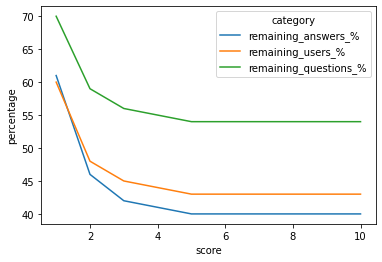

In [6]:
import seaborn as sns

values_df = pd.DataFrame(columns=["score", "percentage", "category"])
for i in range(1, 11):
    answers_per = int((answers[(answers.score>=i) | (answers.is_accepted_answer==1)].answer_id.count()/answers.answer_id.count())*100)
    print(f"% of remaining answers having been accepted or score>={i}:", answers_per, "%")
    users_per = int((answers[(answers.score>=i) | (answers.is_accepted_answer==1)].user_id.nunique()/answers.user_id.nunique())*100)
    print(f"% of remaining users having answers accepted or score>={i}:", users_per, "%")
    questions_per = int((answers[(answers.score>=i) | (answers.is_accepted_answer==1)].question_id.nunique()/answers.question_id.nunique())*100)
    print(f"% of remaining questions having answers accepted or score>={i}:", questions_per, "%")
    print("\n")
    values_df = values_df.append([{"score": i, "percentage": answers_per, "category": "remaining_answers_%"},
                     {"score": i, "percentage": users_per, "category": "remaining_users_%"},
                     {"score": i, "percentage": questions_per, "category": "remaining_questions_%"}], ignore_index=True)
sns.lineplot(data=values_df, x="score", y="percentage", hue="category")

The most discriminant threshold seems to be 2, with higher score we have no significant differences as the probability of accepted answer is higher.  
The choice of this threshold is a business choice related to the use case we want to implement. For now let's take only answer with **at least 1 upvote**.

In [7]:
from utils import get_positive_interactions

In [8]:
positive_answers, negative_answers = get_positive_interactions(answers, 1, "score", True)

## Train Test Val

Let's define the pct of the test size and the composition of this test dataset in term of cold start and warm start rows

In [9]:
test_eval_size = 0.15
eval_size = 0.5
cold_start_size = 0.5
warm_start_size = 1-cold_start_size
random_state = 42

### Test

#### Cold start

Define the strategy of test train split for cold start, i.e the question hasn't been seen in the training dataset.

--> User Split Strategy from https://arxiv.org/pdf/2007.13237.pdf

In [10]:
from utils import metric_to_classes
from sklearn.model_selection import train_test_split

As cold start concern the question we will take unique question_id

In [11]:
questions_from_positive = positive_answers[["question_id", "question_nb_answers"]].drop_duplicates(subset="question_id").reset_index(drop=True)

I choose to use the number of answer related to a question to stratify my split (other choices are possible such as the average of answers score).  
We will classify the feature in 3 labels: High, Medium, low based on percentiles and use these labels in our split.

In [12]:
questions_from_positive.question_nb_answers.describe(percentiles=[0.5,0.6,0.7,0.8,0.85,0.9,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1])

count    50154.000000
mean         1.406986
std          0.721898
min          1.000000
50%          1.000000
60%          1.000000
70%          2.000000
80%          2.000000
85%          2.000000
90%          2.000000
92%          2.000000
93%          3.000000
94%          3.000000
95%          3.000000
96%          3.000000
97%          3.000000
98%          3.000000
99%          4.000000
100%        16.000000
max         16.000000
Name: question_nb_answers, dtype: float64

In [13]:
# Transform question_nb_answers to classes to stratify split
questions_from_positive["question_label"] = metric_to_classes(questions_from_positive.question_nb_answers, 0.99, 0.7)

# Split questions in test_eval dataset
_, test_eval_cold_start_questions = train_test_split(questions_from_positive[["question_id", "question_label"]], test_size=test_eval_size*cold_start_size, random_state=random_state, stratify=questions_from_positive["question_label"])

# Split test_eval dataset into test and eval
test_cold_start_questions, eval_cold_start_questions = train_test_split(test_eval_cold_start_questions[["question_id"]], test_size=eval_size, random_state=random_state, stratify=test_eval_cold_start_questions["question_label"])

# Merge test questions with answers
test_cold_start = test_cold_start_questions.merge(answers, on="question_id")
print("test cs shape", test_cold_start.shape, "\ntest cs nb unique questions",test_cold_start.question_id.nunique())

# Merge eval questions with answers
eval_cold_start = eval_cold_start_questions.merge(answers, on="question_id")
print("test cs shape", eval_cold_start.shape, "\ntest cs nb unique questions",eval_cold_start.question_id.nunique())

test cs shape (2662, 10) 
test cs nb unique questions 1881
test cs shape (2665, 10) 
test cs nb unique questions 1881


#### Warm start

Define the strategy of test train split for warm start, i.e the question has been seen in the training dataset.

--> Leave One Last Item Strategy from https://arxiv.org/pdf/2007.13237.pdf

In [14]:
import math

In [15]:
# Compute number of questions to take for warm start
warm_start_test_nb = int(warm_start_size*(test_cold_start_questions.size + eval_cold_start_questions.size)/cold_start_size)

# Remove cold start questions
questions_from_positive_without_cold_start = questions_from_positive[~questions_from_positive.question_id.isin(test_eval_cold_start_questions.question_id.tolist())]

# Split warm start corpus into test_eval dataset 
questions_from_positive_without_cold_start = questions_from_positive_without_cold_start[questions_from_positive_without_cold_start.question_nb_answers>=2]
_, test_eval_warm_start_questions = train_test_split(questions_from_positive_without_cold_start[["question_id", "question_label"]], test_size=warm_start_test_nb, random_state=random_state, stratify=questions_from_positive_without_cold_start["question_label"])

# Get test and eval questions
test_warm_start_questions, eval_warm_start_questions = train_test_split(test_eval_warm_start_questions[["question_id"]], test_size=eval_size, random_state=random_state, stratify=test_eval_warm_start_questions["question_label"])

# Get answers from warm start questions
test_warm_start_answers = answers[answers.question_id.isin(test_warm_start_questions.question_id.tolist())]
eval_warm_start_answers = answers[answers.question_id.isin(eval_warm_start_questions.question_id.tolist())]

# Group by question_id
test_warm_start_answers_group = test_warm_start_answers.groupby("question_id")
eval_warm_start_answers_group = eval_warm_start_answers.groupby("question_id")

# For each questions keep only x rate of last answers
rate_last_answers = 0.3
test_warm_start = test_warm_start_answers_group.apply(lambda x: x.sort_values(by="date", ascending=False).head(math.ceil(x.size*rate_last_answers))).reset_index(drop=True)
eval_warm_start = eval_warm_start_answers_group.apply(lambda x: x.sort_values(by="date", ascending=False).head(math.ceil(x.size*rate_last_answers))).reset_index(drop=True)

In [16]:
test_warm_start.shape

(4352, 10)

In [17]:
eval_warm_start.shape

(4365, 10)

#### Global

In [18]:
test = (test_warm_start, test_cold_start)
eval_ds = (eval_warm_start, eval_cold_start)

In [19]:
print((test_warm_start.shape[0] + test_cold_start.shape[0], test_warm_start.shape[1]))
print((eval_warm_start.shape[0] + eval_cold_start.shape[0], eval_warm_start.shape[1]))

(7014, 10)
(7030, 10)


In [20]:
test_eval_answers = test_warm_start.answer_id.tolist() + test_cold_start.answer_id.tolist() + eval_warm_start.answer_id.tolist() + eval_cold_start.answer_id.tolist()

### Train

In [21]:
train = positive_answers[~positive_answers.answer_id.isin(test_eval_answers)]

In [22]:
train.shape

(48481, 10)

In [23]:
train.question_id.nunique()

42630

In [24]:
train.answer_id.isin(test_eval_answers).sum()

0

### Serialize Datasets

In [25]:
from utils import Serializer, ESerializerExtension, SERIALIZED_DATA_ARTIFACT_NAMES

In [26]:
serializer = Serializer()

In [27]:
serializer(train, "../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_train_dataset ,ESerializerExtension.CSV, "Train dataset")

serializer(test_warm_start, "../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_test_warm_start_dataset ,ESerializerExtension.CSV, "Test dataset for warm start")

serializer(test_cold_start, "../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_test_cold_start_dataset ,ESerializerExtension.CSV, "Test dataset for cold start")

serializer(eval_warm_start, "../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_eval_warm_start_dataset ,ESerializerExtension.CSV, "Eval dataset for warm start")

serializer(eval_cold_start, "../"+SERIALIZED_DATA_ARTIFACT_NAMES.path_to_eval_cold_start_dataset ,ESerializerExtension.CSV, "Eval dataset for cold start")

2022-07-16 14:40:02,475 :: _log_serialization :: INFO :: Serialize object to /home/okteto/user_recommendation/data/datasets/train.csv as ESerializerExtension.CSV. Object description: Train dataset
2022-07-16 14:40:04,277 :: __call__ :: INFO :: Object correctly stored
2022-07-16 14:40:04,279 :: _log_serialization :: INFO :: Serialize object to /home/okteto/user_recommendation/data/datasets/test_warm_start.csv as ESerializerExtension.CSV. Object description: Test dataset for warm start
2022-07-16 14:40:04,425 :: __call__ :: INFO :: Object correctly stored
2022-07-16 14:40:04,426 :: _log_serialization :: INFO :: Serialize object to /home/okteto/user_recommendation/data/datasets/test_cold_start.csv as ESerializerExtension.CSV. Object description: Test dataset for cold start
2022-07-16 14:40:04,520 :: __call__ :: INFO :: Object correctly stored
2022-07-16 14:40:04,521 :: _log_serialization :: INFO :: Serialize object to /home/okteto/user_recommendation/data/datasets/eval_warm_start.csv as E